# Ageing Score Calculation
## Xiaonan Wang
## 20May2023

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


In [2]:
adata = sc.read('./write/Ageing_processed.h5ad')

In [3]:
# Extract out the Immature and HSC cells
adata[(adata.obs['Dahlin_CT'] == 'Immature') | (adata.obs['Dahlin_CT'] == 'HSC')].write('Immature_HSC.h5ad')

In [4]:
adata.write('./write/Immature_HSC.h5ad')

# Calculate Ageing Score

In [5]:
adata = sc.read('./write/Immature_HSC.h5ad')

In [6]:
AL = np.genfromtxt('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/GSE157832/age_gene20.txt', dtype=str)
print(len(AL))
AL = np.intersect1d(AL, adata.raw.var_names)
print(len(AL))

20
20


In [18]:
print(AL)

['Cd38' 'Clca3a1' 'Clec1a' 'Enpp5' 'Fhl1' 'Gpr183' 'Gstm2' 'Itgb3' 'Klhl4'
 'Mt1' 'Mt2' 'Neo1' 'Nupr1' 'Plscr2' 'Ptprk' 'Sbspon' 'Selp' 'Trpc1' 'Vwf'
 'Zg16']


In [7]:
adata_norm = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, obsm=adata.obsm)

In [8]:
sc.pp.scale(adata_norm)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [9]:
sc.tl.score_genes(adata_norm, AL)

computing score 'score'
    finished: added
    'score', score of gene set (adata.obs).
    400 total control genes are used. (0:00:01)


In [10]:
adata.obs['AS_score'] = adata_norm.obs['score']

In [11]:
LTHSCdata = adata[(adata.obs['Combined_CT'] == 'LTHSC')].copy()

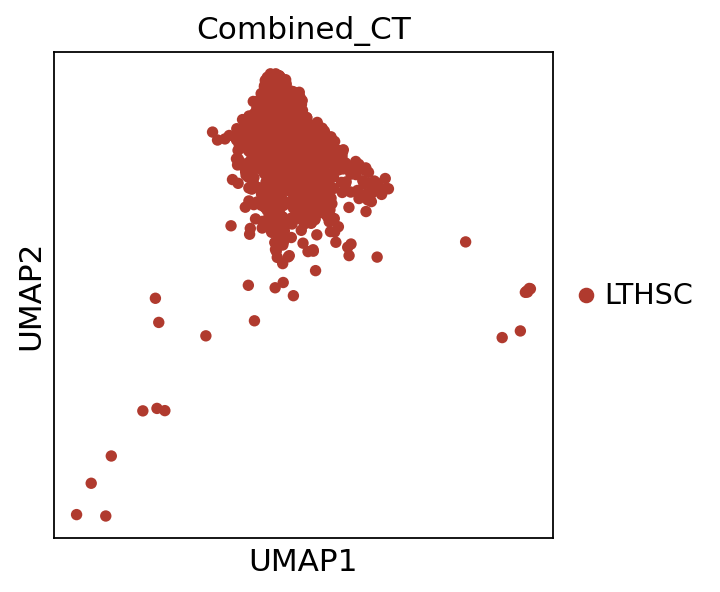

In [12]:
sc.pl.umap(LTHSCdata, color='Combined_CT')

In [13]:
LTHSCdata.obs['Age'].value_counts()

88-week    741
16-week    223
68-week    178
Name: Age, dtype: int64

In [14]:
LTHSCdata.write('./write/LTHSC.h5ad')

In [15]:
LTHSCdata.obs['Age'] = LTHSCdata.obs['Age'].cat.reorder_categories(['16-week', '68-week', '88-week'])

68-week v.s. 88-week: Mann-Whitney-Wilcoxon test two-sided, P_val=2.526e-20 U_stat=3.657e+04
16-week v.s. 68-week: Mann-Whitney-Wilcoxon test two-sided, P_val=1.529e-17 U_stat=1.002e+04
16-week v.s. 88-week: Mann-Whitney-Wilcoxon test two-sided, P_val=1.976e-65 U_stat=2.035e+04


(<AxesSubplot:title={'center':'LTHSC'}, ylabel='Ageing score'>,
  <statannot.StatResult.StatResult at 0x2af0afb53c70>])

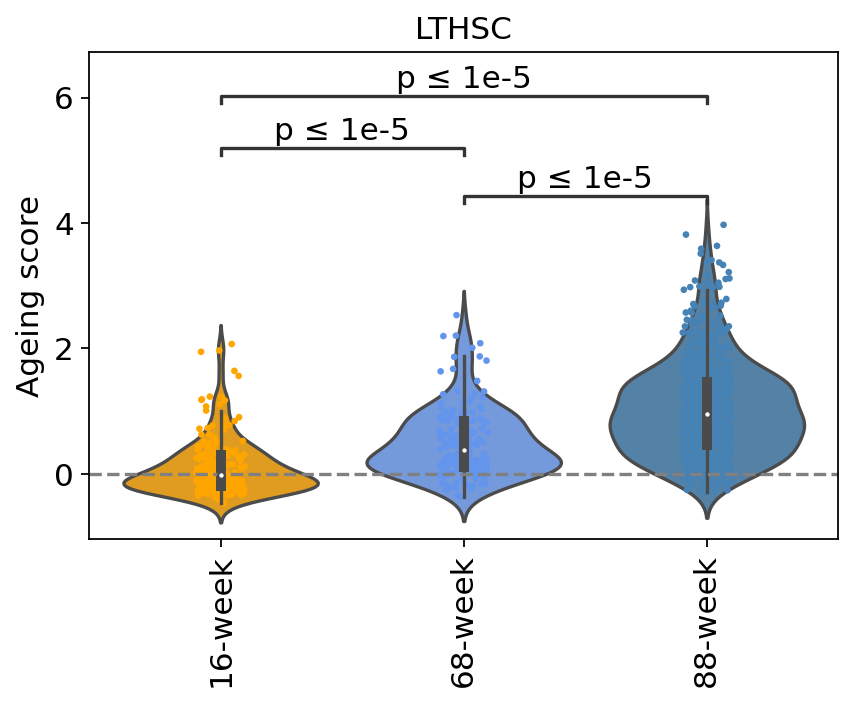

In [17]:
# Figure 2A
from statannot import add_stat_annotation
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
df = LTHSCdata.obs[['AS_score', 'Age']]
sns.violinplot(x='Age', y='AS_score', scale='width', data=df,ax=ax, palette=['orange', '#6495ED', '#4682B4'])
sns.stripplot(x="Age", y="AS_score", data=df, jitter=True, size=3, zorder=1, color=".3",ax=ax, palette=['orange', '#6495ED', '#4682B4'])
ax.grid(False)
ax.set_title('LTHSC')
ax.set_xlabel('')
ax.set_ylabel('Ageing score')
ax.axhline(0, linestyle='--', color='grey')
ax.set_xticklabels(labels=df['Age'].cat.categories,rotation=90)
add_stat_annotation(ax, data=df, x='Age', y='AS_score',
                    box_pairs=[('68-week',  '88-week'),
                              ('88-week', '16-week'),
                              ('68-week', '16-week')],comparisons_correction=None,
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)